In [4]:
import sys
sys.path.append("..")

In [5]:
from config import *

In [6]:
TPU_MODE=False
SHUFFLE=False

In [7]:
import ipywidgets as widgets
import datetime
import tensorflow as tf

import dataset_functions
from models.six_stage_linear_model import ModelMaker
import callbacks
import dataset_builder
import load_weights

In [8]:
import matplotlib.pyplot as plt
import visualizations as v

In [9]:
tfrecord_files_train,tfrecord_files_val=dataset_builder.get_tfrecord_filenames()
print("Found the following val TFrecords:\n","\n".join(tfrecord_files_val))

print("Building training dataset")
dst=dataset_builder.build_training_ds(tfrecord_files_train)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder.build_validation_ds(tfrecord_files_val)
print("Validation dataset shape:",dsv)

Retrieving TFrecords in TPU_mode
Found the following val TFrecords:
 gs://datasets_bucket_a/validation-001.tfrecords
gs://datasets_bucket_a/validation-002.tfrecords
gs://datasets_bucket_a/validation-003.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <BatchDataset shapes: (((None, 368, 368, 3), (None, 46, 46, 1)), ((None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 35), (None, 46, 46, 19), (None, 46, 46, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


In [10]:
#model_path="gs://dl_training_results/models/Epoch18-Not_Working_On_Pafs-02Mon1219-1642"
checkpoint="gs://dl_training_results/checkpoints//08Sun1219-1300/Checkpoint-E0015.ckpt"

In [11]:
model_maker=ModelMaker() #must be outside scope to keep the graph clean
tf.keras.backend.clear_session() #to clean to backaend from the imported model

train_model,test_model=model_maker.create_models()
if (checkpoint):
    train_model.load_weights(checkpoint)

In [19]:
model_name="First_success"

In [20]:
model_path=MODELS_PATH+model_name+"-"+datetime.datetime.now().strftime("%d(%a)%m%y-%H%M")
tf.keras.models.save_model(train_model,model_path)

INFO:tensorflow:Assets written to: gs://dl_training_results/models/First_success-08(Sun)1219-2245/assets


---
## Dataset input (truth)

In [13]:
#service functions
def remove_mask(inp):
    return inp[...,:-1]
def decmopose_ds_elem(st,idx):
    img=st[0][0][idx:idx+1].numpy()
    paf=st[1][3][idx:idx+1].numpy()
    kpt=st[1][5][idx:idx+1].numpy()
    
    paf=remove_mask(paf)
    kpt=remove_mask(kpt)
    return img,(paf,),(kpt,)

def get_train_model_output(model,st,idx):
    
    img=st[0][0][idx:idx+1].numpy() #get img from sample tensor
    empty_mask=np.zeros((1,46,46,1)) #generate mask
    inputs=(img,empty_mask) #bundle
    
    pred_t=train_model.predict(inputs) #actual prediction
    
    paf0=remove_mask(pred_t[0])
    paf1=remove_mask(pred_t[1])
    paf2=remove_mask(pred_t[2])
    paf3=remove_mask(pred_t[3])
    kpt0=remove_mask(pred_t[4])
    kpt1=remove_mask(pred_t[5])
    
    return img,(paf0,paf1,paf2,paf3),(kpt0,kpt1)

def extract_single_paf(paf,idx):
    ldim=int(paf.shape[-1]/2)
    return np.stack([paf[...,idx],paf[...,idx+ldim]],axis=-1)

In [14]:
st=next(iter(dst))
idx=0

In [16]:
joint_num=-1 #-1 to show all, otherwise joint num to isolate

In [25]:
idx=idx+1

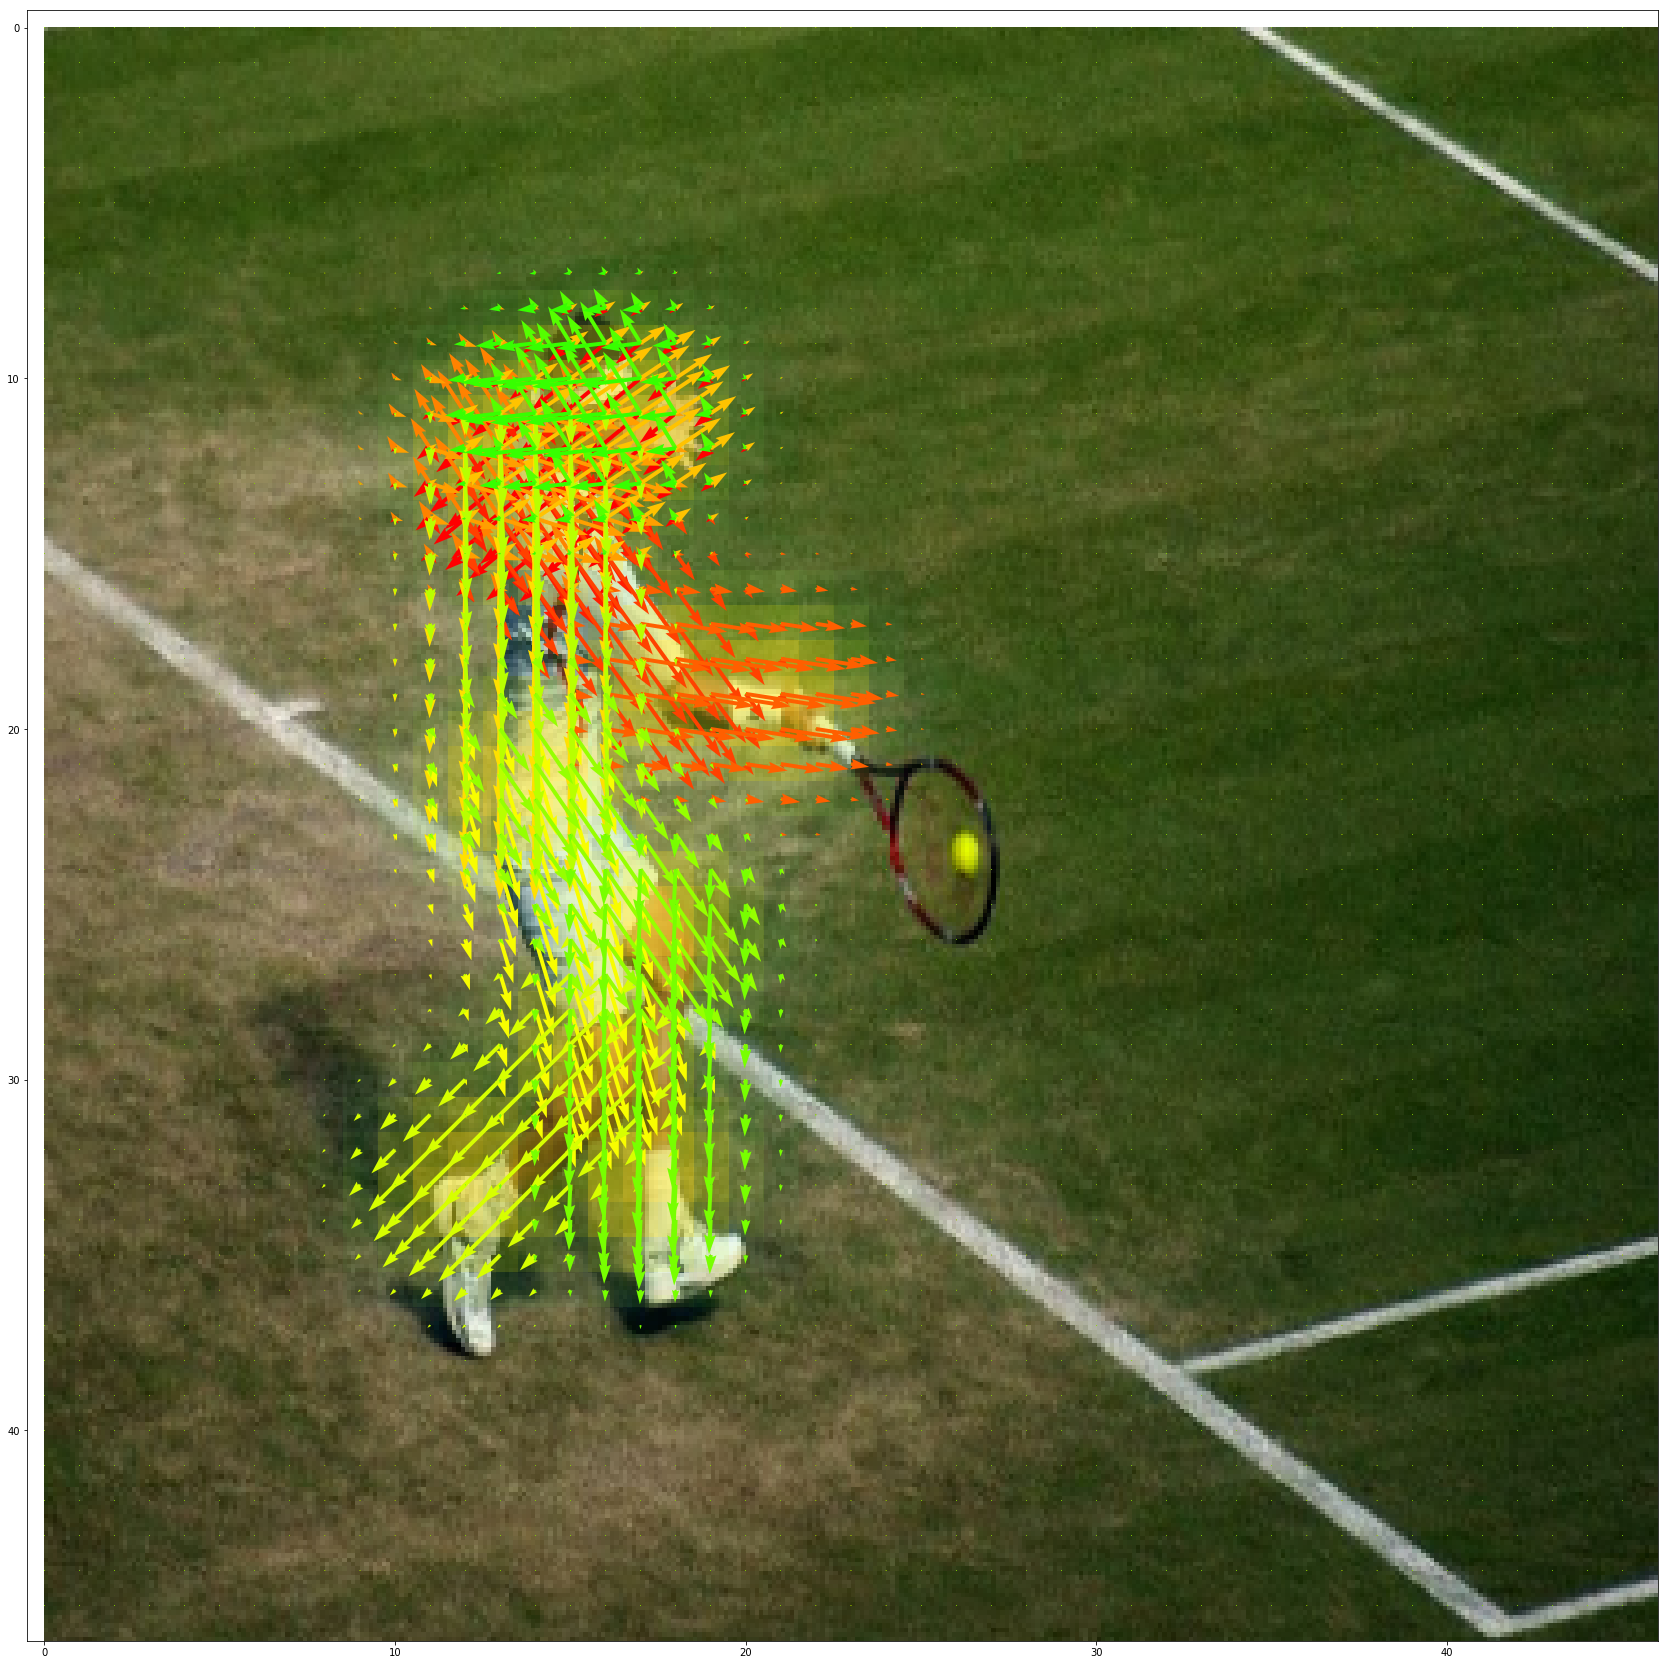

In [26]:
img,(paf,),(kpt,)=decmopose_ds_elem(st,idx)
if joint_num>0:
    paf=extract_single_paf(paf,joint_num)
v.show_img_pafs_kpts(img,paf,kpt,figure_size=30)

---
## Model prediction

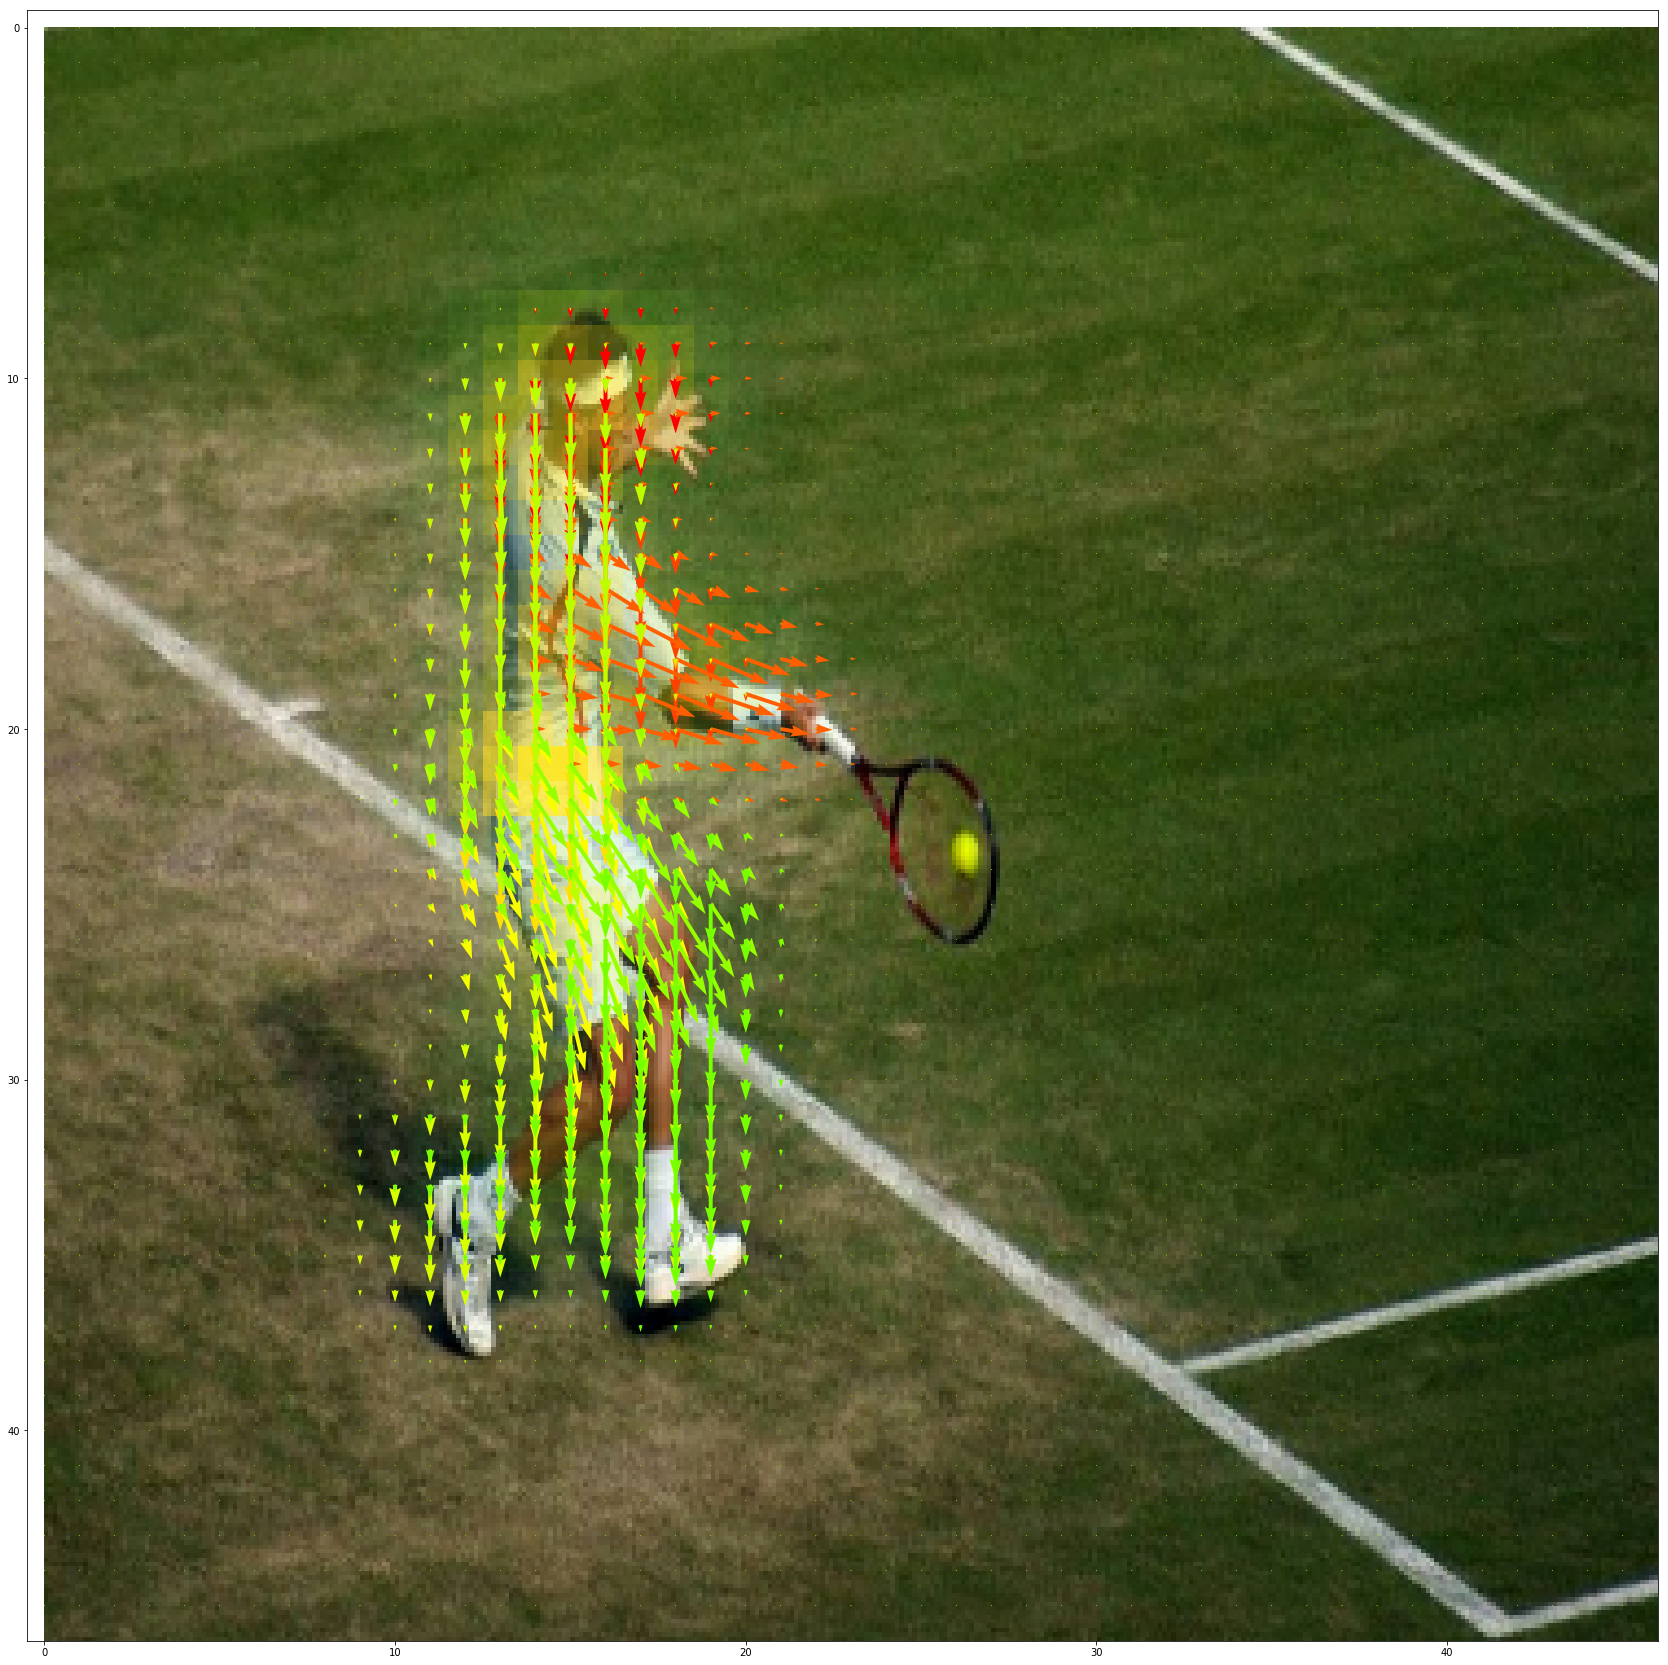

In [27]:
img,(paf0,paf1,paf2,paf3),(kpt0,kpt1)=get_train_model_output(train_model,st,idx)
paf=paf2 #select the outoput to check
kpt=kpt0
if joint_num>0:
    paf=extract_single_paf(paf,joint_num)
v.show_img_pafs_kpts(img,paf,kpt,figure_size=30)

In [ ]:
plt.imshow(pred_paf2[0,...,0+17])
plt.colorbar()

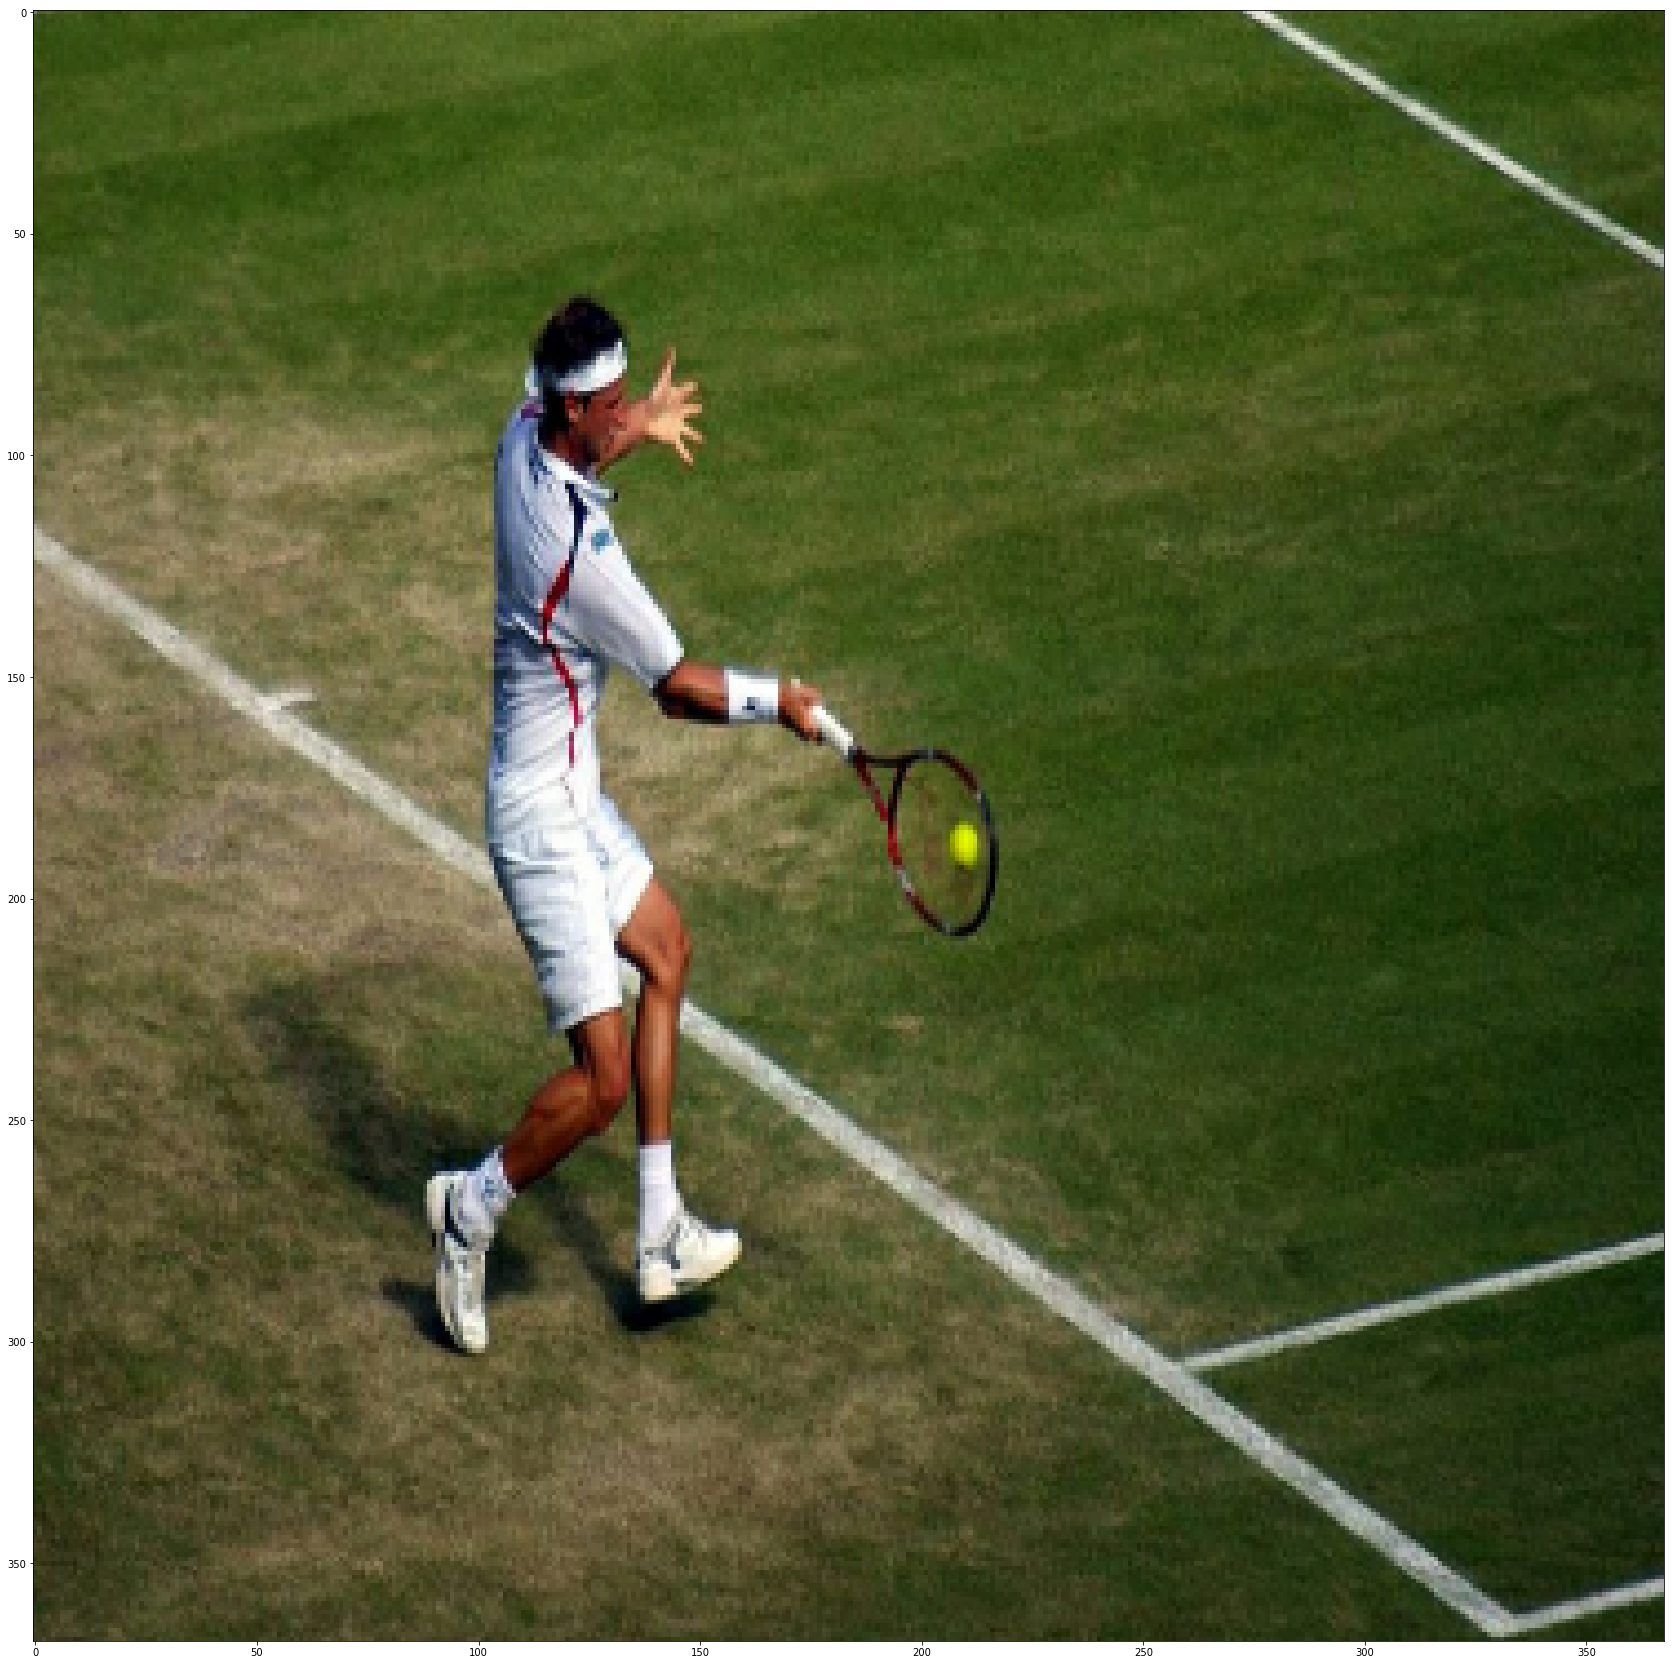

In [35]:
plt.figure(figsize=(30,30))
plt.imshow(img[0])